In [1]:
from pathlib import Path
import sys
sys.path.append("../")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from scripts import theodolite_utils as theodo_u


In [2]:
model = "0_0_0_0_0_5"

experiment_paths = [
    Path(p)
    for p in (
        "../data/20220224/",
        "../data/20220307/",
        "../data/20220312/",
        "../data/20220314/",
        "../data/20220316/",
        "../data/20220331-1/",
        "../data/20220331-2/",
        "../data/20220427-1/",
        "../data/20220427-2/",
        "../data/20220513-1/",
        "../data/20220513-2/",
        "../data/20220513-3/",
        "../data/20220513-4/",
        # "../data/20220513-5/",
        # "../data/20220513-6/",
        "../data/20220525-1/",
        "../data/20220525-2/",
        "../data/20220622-1/",
        "../data/20220622-2/",
        "../data/20220630-1/",
        "../data/20220630-2/",
        # "../data/20220711-1/",
        "../data/20220711-2/",
        "../data/20221103-1/",
        "../data/20221103-2/",
        "../data/20221103-3/",
        "../data/20221109-1/",
        "../data/20221109-2/",
        "../data/20221109-3/",
        "../data/20221110/",
        "../data/20221116-1/",
        "../data/20221123/",
        # "../data/20221124/",
        "../data/20221129-1/",
        "../data/20221129-2/",
        "../data/20221129-3/",
        # "../data/20221129-4/",
        "../data/20221129-5/",
        "../data/20221205-1/",
        # "../data/20221205-2/",
        "../data/20221205-3/",
    )
]


In [3]:
models = {
    "Instrument": "1_0_0_0_0",
    "Tilt": "1_1_0_0_0",
    "Atmospheric": "1_0_1_0_0",
    "Extrinsic": "1_0_0_1_0",
    "Time": "1_0_0_0_1",
    "All": "1_1_1_1_1",
}
columns = (
    ["time", "mx", "my", "mz"]
    + [f"Sp{i}" for i in range(9)]
    + ["r", "p", "y"]
    + [f"Sa{i}" for i in range(9)]
)
orig_dfs = {mname: {} for mname in models.keys()}
ignored_dates = ["20220513-5", "20220711-1", "20221124", "20221129-4", "20221205-2"]
for pat in tqdm(experiment_paths):
    uncertainty_data = pat / "uncertainty"
    sensor_data = uncertainty_data / "sensor"
    date = str(pat.stem)
    for mname, mcode in models.items():
        GNSS_path = sensor_data / f"GNSS_{mcode}_0.csv"
        if not date in ignored_dates:
            orig_dfs[mname][date] = pd.read_csv(
                GNSS_path, sep=" ", names=columns, header=None
            )


100%|██████████| 35/35 [00:03<00:00, 11.10it/s]


In [4]:
# concat_prisms = {l:{lab:pd.concat(df, ignore_index=True)for lab, df in mod.items()} for l, mod in prisms_dfs.items()}
concat_dfs = {l:pd.concat(df.values(), ignore_index=True) for l, df in orig_dfs.items()}
# concat_dists = {l:pd.concat(df.values(), ignore_index=True) for l, df in dist_dfs.items()}

In [5]:
# for mod in models:
#     print(mod, concat_prisms[mod]["P1"].shape)
#     print(mod, concat_prisms[mod]["P2"].shape)
#     print(mod, concat_prisms[mod]["P3"].shape)
#     print(mod, concat_dfs[mod].shape)
#     concat_prisms[mod]["P1"].iloc[:concat_dfs[mod].shape[0]]
# def apply_frobenius(df):
#     pose_covariance = [f"Sa{i}" for i in range(9)]
#     poscovs = {
#         l: df[pose_covariance].copy()
#         for l, df in concat_dfs.items()
#     }
#     f = 1_000_000
#     f = 1
#     all_frobs = poscovs["All"].copy().to_numpy()
#     all_mat = [spdf[i, :].reshape((3, 3)) for i in range(all_frobs.shape[0])]
#     for l, df in poscovs.items():
#         spdf = df[pose_covariance].copy().to_numpy()
#         mats = [spdf[i, :].reshape((3, 3)) for i in range(spdf.shape[0])]
#         df["frob"] = f * pd.Series(
#             [
#                 np.linalg.norm(spdf[i, :].reshape((3, 3)), ord="fro")
#                 for i in range(spdf.shape[0])
#             ]
#         )
#     frobs = {l:df.frob for l, df in poscovs.items()}

In [6]:
pose_covariance = [f"Sa{i}" for i in range(9)]
poscovs = {
    l: df[pose_covariance].copy()
    for l, df in concat_dfs.items()
}
f = 1_000_000
f = 1
for l, df in poscovs.items():
    spdf = df[pose_covariance].copy().to_numpy()
    mats = [spdf[i, :].reshape((3, 3)) for i in range(spdf.shape[0])]
    df["frobp"] = f * pd.Series(
        [
            np.linalg.norm(spdf[i, :].reshape((3, 3)), ord="fro")
            for i in range(spdf.shape[0])
        ]
    )
frobps = {l:np.sqrt(df.frobp) for l, df in poscovs.items()}


ori_covariance = [f"Sp{i}" for i in range(9)]
oricovs = {
    l: df[ori_covariance].copy()
    for l, df in concat_dfs.items()
}
f = 1_000_000
f = 1
for l, df in oricovs.items():
    spdf = df[ori_covariance].copy().to_numpy()
    mats = [spdf[i, :].reshape((3, 3)) for i in range(spdf.shape[0])]
    df["froba"] = f * pd.Series(
        [
            np.linalg.norm(spdf[i, :].reshape((3, 3)), ord="fro")
            for i in range(spdf.shape[0])
        ]
    )
frobas = {l:np.sqrt(df.froba) for l, df in oricovs.items()}



In [7]:

series = {}
for mname in models:
    series.setdefault(mname, {})["pos"] = frobps[mname]
    series.setdefault(mname, {})["ori"] = frobas[mname]




In [8]:
import itertools
# f = 1_000_000
f = 1
pos_data = [(series[mname]["pos"] / f).dropna().to_list() for mname in models]
ori_data = [(series[mname]["ori"] / f).dropna().to_list() for mname in models]
# data = [(series[mname]["pos"] / f, series[mname]["ori"] / f) for mname in models]
# data = [elem.dropna().to_list() for elem in itertools.chain(*data)]

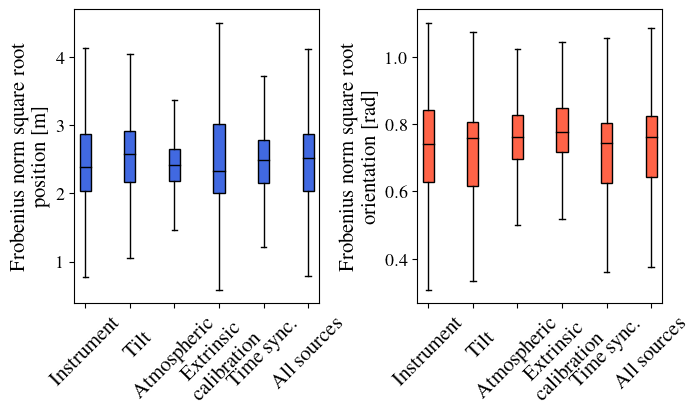

In [77]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)
font_size = 15

width = 3.487
height = width / 1.618

fig, (ax1, ax2) = plt.subplots(1, 2)
box1 = ax1.boxplot(pos_data, positions=[2*x+1 for x in range(6)], showfliers=False, notch=False, patch_artist=True)
box2 = ax2.boxplot(ori_data, positions=[2*x+1 for x in range(6)], showfliers=False, notch=False, patch_artist=True)

tickslabs = [
    "Instrument",
    "\n Tilt",
    "Atmospheric",
    "Extrinsic\ncalibration",
    "Time sync.",
    "All sources",
]

ax1.set_xticks(
    ticks=[1, 3, 5, 7, 9, 11],
    labels=tickslabs,
    fontsize=font_size,
    ha="center",
    ma="center",
    rotation=45,
)

ax2.set_xticks(
    ticks=[1, 3, 5, 7, 9, 11],
    labels=tickslabs,
    fontsize=font_size,
    ha="center",
    ma="center",
    rotation=45,
)

ax1.tick_params(axis="x", which="major", labelsize=font_size, rotation=45)
ax2.tick_params(axis="x", which="major", labelsize=font_size, rotation=45)

#ax.tick_params(axis='y', labelcolor="royalblue", color="royalblue")
#ax2.tick_params(axis='y', labelcolor="tomato", color="tomato")

colors = [
    "royalblue",
    "tomato",  # , 'pink',
    "royalblue",
    "tomato",  # , 'pink',
    "royalblue",
    "tomato",  # , 'pink',
    "royalblue",
    "tomato",  # , 'pink',
    "royalblue",
    "tomato",  # , 'pink',
    "royalblue",
    "tomato",
]  # , 'pink']
for patch in box1["boxes"]:
    patch.set_facecolor("royalblue")
for patch in box2["boxes"]:
    patch.set_facecolor("tomato")

for median in box1["medians"]:
    median.set_color("black")
for median in box2["medians"]:
    median.set_color("black")

ax1.set_ylabel("Frobenius norm square root\n position [m]", fontsize=font_size, color="black")
ax2.set_ylabel("Frobenius norm square root\n orientation [rad]", fontsize=font_size, color="black")

# plt.legend(
#     handles=[
#         box1["boxes"][0],
#         box2["boxes"][0],
#     ],  # , box["boxes"][4]],
#     handletextpad=0.3,
#     handlelength=1.0,
#     columnspacing=0.8,
#     labels=[
#         f"Position",
#         f"Orientation",
#     ],  # , '125 to 200m', 'More than 200m'],
#     loc="lower center",
#     bbox_to_anchor=(-0.5, 0.99),
#     ncol=4,
#     fontsize=font_size - 3,
# )

width = 6
height = 3

plt.tight_layout()
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99,wspace=0.4)
fig.set_size_inches(width, height)
plt.savefig("../figs/uncertainty/pose_uncertainty_stats.pdf", bbox_inches="tight")
plt.show()
ori_median = [np.median(ori) for ori in ori_data]
pos_median = [np.median(pos) for pos in pos_data]


In [10]:

print("Pos",pos_median, "ori",ori_median, sep="\n")

Pos
[2.3907723246747477, 2.5779920376650542, 2.4116906232160678, 2.326912001527914, 2.487742584325134, 2.5209812282856205]
ori
[0.7405636208236739, 0.7573511854483342, 0.7605390847810958, 0.7761037237138372, 0.7430283637577262, 0.7598443115713347]


In [11]:
np.median(ori_median)

0.7585977485098345

In [12]:
pose_covariance = [f"Sp{i}" for i in range(9)]
poscovs = {
    l: df[pose_covariance].dropna().copy()
    for l, df in concat_dfs.items()
    if l in models
}
for l, df in poscovs.items():
    df["sumcov"] = df.Sp0 + df.Sp4 + df.Sp8
    df["covxyz"] = np.sqrt(df.sumcov)
    spdf = df[pose_covariance].copy().to_numpy()
    mats = [spdf[i, :].reshape((3, 3)) for i in range(spdf.shape[0])]
    df["frob"] = 1_000_000 * pd.Series(
        [
            np.linalg.norm(spdf[i, :].reshape((3, 3)), ord="fro")
            for i in range(spdf.shape[0])
        ]
    )
